In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
pd.options.mode.chained_assignment = None  # default='warn'

import os
if os.path.exists('logging.log'):
    os.remove('logging.log')
    print("File removed")
else:
    print("The file does not exist") 

import logging
logging.basicConfig(filename='logging.log', format='%(asctime)s - %(levelname)s: \t%(message)s', datefmt='%d/%m/%Y %I:%M:%S: %p',  level=logging.DEBUG)
logging.info('File di logging inizializzato.')

The file does not exist


In [2]:
df = pd.read_excel('data/IncidentiModificato.xlsx', index_col='VERBALE')
df = df.drop(columns=["DATA"])
X = df[['SESSO', 'ANNI', 'PESO', 'ALTEZZA', 'BMI', 'Tot Testa', 'Tot Torace', 'Tot Addome', 'Tot Scheletro']]
y = df['Mezzo']

df.head()

,SESSO,ANNI,PESO,ALTEZZA,BMI,Mezzo,Testa:Neurocranio,Testa:Splancnocranio,Testa:Telencefalo,Testa:Cervelletto,...,Scheletro:Rachide-cervicale,Scheletro:Rachide-toracico,Scheletro:Rachide-lombare,Scheletro:Bacino-e-sacro,Scheletro:Complesso-sterno/claveo/costale,Tot Testa,Tot Torace,Tot Addome,Tot Scheletro,Totale
VERBALE,,,,,,,,,,,,,,,,,,,,,
85567,0,81,84.0,1.75,27.428571,0,1,0,0,0,...,0,3,0,3,3,2,0,3,9,14
85829,1,69,69.0,1.62,26.291724,1,4,4,4,4,...,0,0,0,0,4,20,7,1,4,32
85977,1,71,67.0,1.55,27.887617,1,2,0,1,1,...,0,0,0,0,4,6,0,0,4,10
86220,1,54,60.0,1.59,23.733238,1,4,0,0,1,...,0,0,0,0,4,5,3,2,4,14
86247,1,78,69.0,1.67,24.740937,1,2,0,0,0,...,0,0,0,0,4,2,0,2,4,8


In [3]:
def get_X_pca_totals(dataframe, exclude=None):
    features = ['SESSO', 'ANNI', 'PESO', 'ALTEZZA','BMI']

    if exclude:
        try:
            features.remove(exclude)
        except:
            features = [f for f in features if f not in exclude]
        
    X_pca = dataframe[features]

    for parte_corpo in ['Testa', 'Torace', 'Addome', 'Scheletro']:
        pca = PCA(n_components=1).fit_transform(dataframe.filter(regex=parte_corpo+":"))
        X_pca['PCA ' + parte_corpo] = pca
    
    return X_pca

def integer_perturbation(n, x):
    if n + x >= 0 and n + x <= 4:
        return n + x
    else:
        return n - x
    
def contains_at_least_one(exclude, ls):
    return True in list(map(lambda x: x in ls, exclude))
    
def add_new_elements_pca(df, perturbation_kind="personal_data", error_distrib = None, n_elements=200, n_columns=3, exclude=None, excluded_feature=None):
    assert(perturbation_kind in ['personal_data', 'body_parts', 'both'])
    df_no_totals = df.drop(columns=df.columns[-5:]) #tolgo i totali per ricalcolarli dopo
    dati_persona = ['SESSO', 'ANNI', 'PESO', 'ALTEZZA', 'BMI', 'Mezzo']
    if exclude:
        try:
            dati_persona.remove(exclude)
        except:
            dati_persona = [f for f in dati_persona if f not in exclude]
            
    df_dati_persona = df_no_totals[dati_persona]
    df_parti_corpo = df_no_totals.drop(columns=dati_persona)
    if error_distrib:
        x = error_distrib['x']
        px = error_distrib['px']
    
    count_elements = 0
    
    logging.info('Started augmentation excluding: {0}, n_elements: {1}'.format(exclude, n_elements))
    while len(df_no_totals) < n_elements:
        index = np.random.choice(df_parti_corpo.index)
        new_index = "FAKE_" + str(index) + "_" + str(count_elements)
        count_elements+=1
        
        parti_corpo = df_parti_corpo.loc[index]
        dati_persona = df_dati_persona.loc[index]
        
        if perturbation_kind == "body_parts" or perturbation_kind == "both":
            pert = parti_corpo.sample(n_columns) 

            for (i,e) in zip(pert.index, pert.values):
                perturbation = np.random.choice(x,p=px)
                parti_corpo[i] = integer_perturbation(e,perturbation)
        
        if perturbation_kind == "personal_data" or perturbation_kind == "both":
            for (i,e) in zip(dati_persona.index, dati_persona.values):
                if i == 'ANNI':
                    perturbation = np.random.normal(0, 1) #int(np.random.normal(0, 1)) #normale centrata in zero e std = 1 anno
                    dati_persona[i] += perturbation
                if i == 'PESO':
                    perturbation = np.random.normal(0, 2) #round(np.random.normal(0, 2), 1) #normale centrata in zero e std = 2kg
                    dati_persona[i] += perturbation
                if i == 'ALTEZZA':
                    perturbation = np.random.normal(0, 0.01) #round(np.random.normal(0, 0.01), 2) #normale centrata in zero e std = 1cm
                    dati_persona[i] += perturbation
                    
            #RICALCOLO BMI
            if type(exclude) == str:
                if exclude not in ['PESO', 'ALTEZZA', 'BMI']:
                    dati_persona['BMI'] = dati_persona['PESO'] / (dati_persona['ALTEZZA'] ** 2)
                else:
                    if exclude == 'PESO':
                        dati_persona['BMI'] = excluded_feature.loc[index] / (dati_persona['ALTEZZA'] ** 2)
                    if exclude == 'ALTEZZA': 
                        dati_persona['BMI'] = dati_persona['PESO'] / (excluded_feature.loc[index] ** 2)
            elif exclude:
                if contains_at_least_one(exclude, ['PESO', 'ALTEZZA', 'BMI']):
                    if 'BMI' not in exclude and 'ALTEZZA' not in exclude and 'PESO' in exclude :
                        dati_persona['BMI'] = excluded_feature.loc[index]['PESO'] / (dati_persona['ALTEZZA'] ** 2)
                    elif 'BMI' not in exclude and 'ALTEZZA' in exclude and 'PESO' not in exclude :
                        dati_persona['BMI'] = dati_persona['PESO'] / (excluded_feature.loc[index]['ALTEZZA'] ** 2)
            #logging.debug('len(df_no_totals): {0}, dati_persona: {1}'.format(len(df_no_totals), dati_persona))
                    
        new_elem = parti_corpo.append(dati_persona)
        df_no_totals.loc[new_index] = new_elem
        
        df_no_totals = df_no_totals.drop_duplicates()
    
    logging.info('Finished augmentation excluding: {0}, n_elements: {1}'.format(exclude, n_elements))
    X_pca = get_X_pca_totals(df_no_totals, exclude)

    return X_pca, df_no_totals['Mezzo']

In [4]:
def get_accuracies(df, params, _range, perturbation_kind, exclude=None, excluded_feature=None): 
    accuracies = {'n_data' : [], 'activation': [], 'hidden layer sizes' : [], 'alpha' : [], 'best score' : []}
    
    X = get_X_pca_totals(df, exclude)
    y = df['Mezzo']
    
    X_std = StandardScaler().fit_transform(X)
    
    mlp = MLPClassifier(learning_rate_init=0.001, max_iter=5000, learning_rate="adaptive")
    clf = GridSearchCV(mlp, params, n_jobs=-1, cv=5)
    clf.fit(X_std,y)

    accuracies['n_data'].append(len(y))
    accuracies['activation'].append(clf.best_estimator_.activation)
    accuracies['hidden layer sizes'].append(clf.best_estimator_.hidden_layer_sizes)
    accuracies['alpha'].append(clf.best_estimator_.alpha)
    accuracies['best score'].append(clf.best_score_)
    
    error_distrib = {
        'x' : [-1,0,1], #togliere -2 e +2 come perturbazione 
        'px' : [.3,.4,.3] # e modificare px in modo che le probabilità sommino 1
    }   

    for n_data in _range:

        X_os, y_os = add_new_elements_pca(df=df, perturbation_kind=perturbation_kind, error_distrib=error_distrib, n_elements=n_data, n_columns=3, exclude=exclude, excluded_feature=excluded_feature)

        X_os_std = StandardScaler().fit_transform(X_os)

        mlp = MLPClassifier(learning_rate_init=0.001, max_iter=5000, learning_rate="adaptive")
        clf = GridSearchCV(mlp, params, n_jobs=-1, cv=5)
        clf.fit(X_os_std,y_os)

        accuracies['n_data'].append(len(y_os))
        accuracies['activation'].append(clf.best_estimator_.activation)
        accuracies['hidden layer sizes'].append(clf.best_estimator_.hidden_layer_sizes)
        accuracies['alpha'].append(clf.best_estimator_.alpha)
        accuracies['best score'].append(clf.best_score_)

    return pd.DataFrame(accuracies)

In [11]:
params = {'activation': ['relu', 'logistic', 'tanh', 'normal'],
          'hidden_layer_sizes' : [(2), (3,3), (5), (6,3), (5,5),(6), (8), (10), (20)],
          #'alpha' : [0.0001, 0.001, 0.01, 0.1]
         }

#_range = [x for x in range(140, 200, 10)] + [x for x in range(200,2000,100)] + [2**e for e in range(11,15)]
_range = [x for x in range(140, 200, 20)] + [x for x in range(200,2001,200)]

In [12]:
logging.info('Started augmenting data excluding NONE')
accuracies_excluding = {}
accuracies_excluding['NONE'] = get_accuracies(df, params, _range, perturbation_kind="personal_data")

In [13]:
features = ['SESSO', 'ANNI', 'PESO', 'ALTEZZA', 'BMI']
for i in range(len(features)):
    for j in range(len(features)):
        if i < j : 
            excluded_features = [features[i], features[j]]
            logging.info('Started augmenting data excluding {0} and {1}'.format(features[i], features[j]))
            df_new = df.drop(columns=excluded_features)
            df_new['Mezzo'] = y
            accuracies_excluding[features[i] + " " + features[j]] = get_accuracies(df_new, params, _range, perturbation_kind="personal_data", exclude=excluded_features, excluded_feature=df[excluded_features])

In [14]:
logging.info('Started augmenting data excluding NONE')
accuracies_excluding_body_parts = {}
accuracies_excluding_body_parts['NONE'] = get_accuracies(df, params, _range, perturbation_kind="body_parts")

In [15]:
features = ['SESSO', 'ANNI', 'PESO', 'ALTEZZA', 'BMI']
for i in range(len(features)):
    for j in range(len(features)):
        if i < j : 
            excluded_features = [features[i], features[j]]
            logging.info('Started augmenting data excluding {0} and {1}'.format(features[i], features[j]))
            df_new = df.drop(columns= excluded_features)
            df_new['Mezzo'] = y
            accuracies_excluding_body_parts[features[i] + " " + features[j]] = get_accuracies(df_new, params, _range, perturbation_kind="body_parts", exclude=excluded_features, excluded_feature=df[excluded_features])

# Grafici delle accuracy escludendo un elemento alla volta aumentando dati perturbando i dati continui

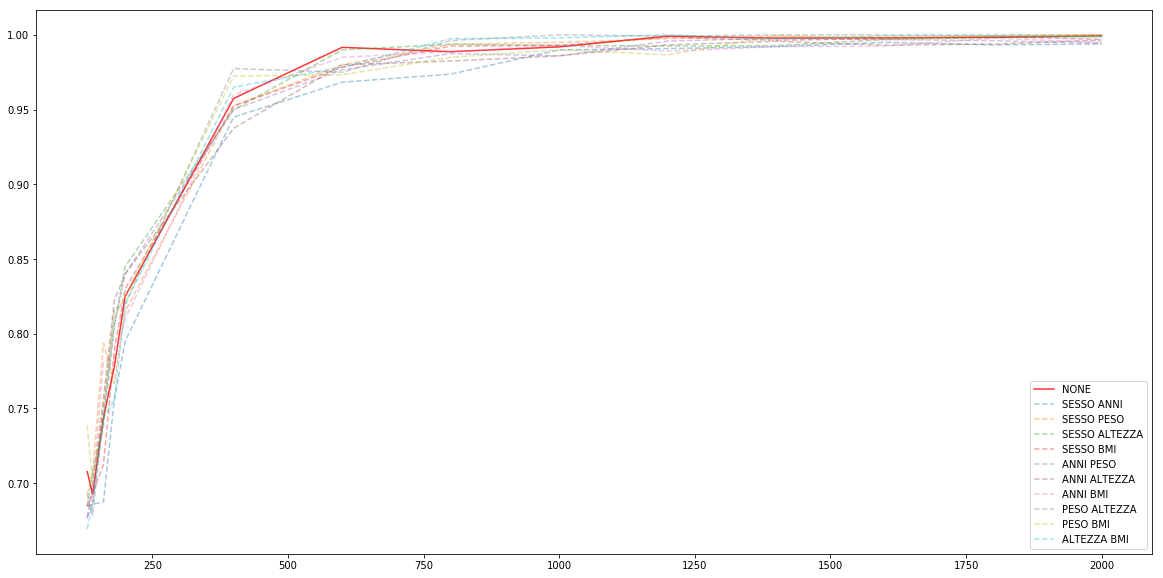

In [17]:
plt.figure(figsize=(20,10))

plt.plot(accuracies_excluding['NONE']['n_data'], accuracies_excluding['NONE']['best score'], alpha=0.8, color='red',label='NONE')

features = ['SESSO', 'ANNI', 'PESO', 'ALTEZZA', 'BMI']
for i in range(len(features)):
    for j in range(len(features)):
        if i < j : 
            excluded = features[i] + " " + features[j]
            plt.plot(accuracies_excluding[excluded]['n_data'], accuracies_excluding[excluded]['best score'], alpha=0.4,  linestyle='--', label=excluded)


plt.legend(loc="lower right")
plt.show()

# Small multiples delle accuracy con reference le accuracy senza esclusioni

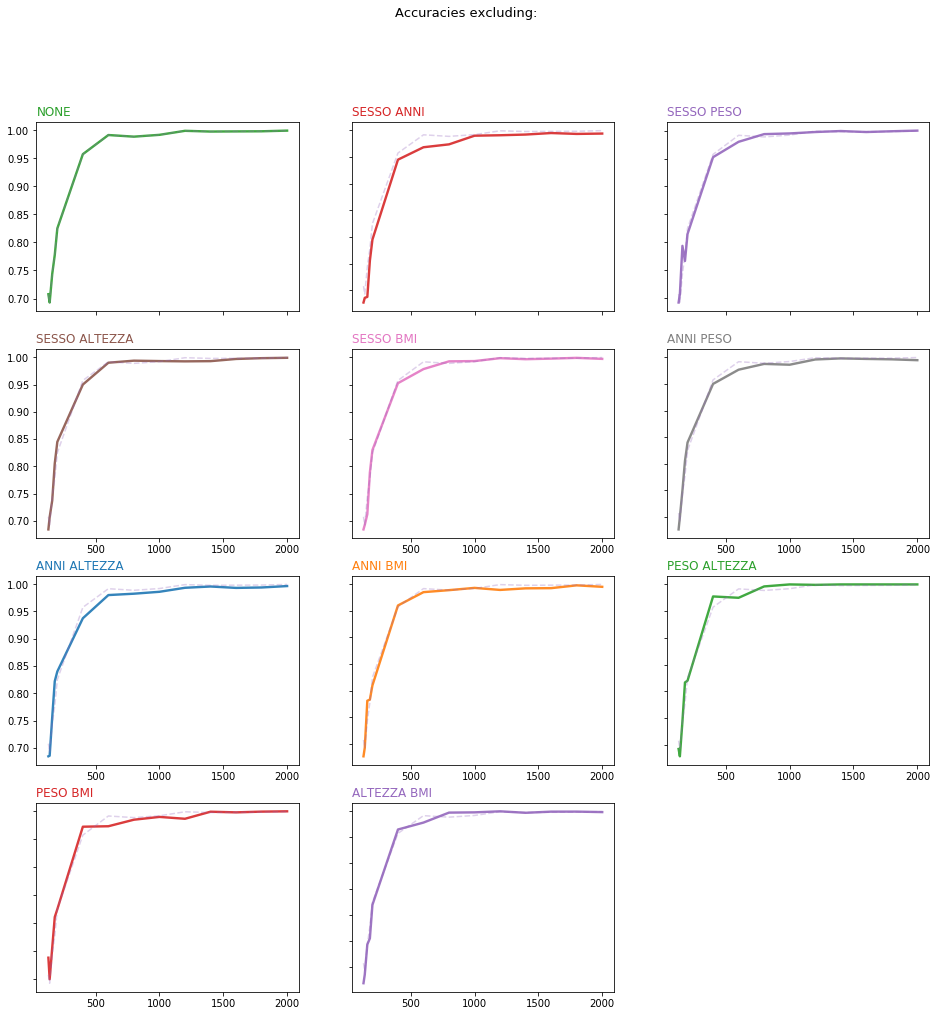

In [18]:
plt.figure(figsize=(16,16))
palette = plt.get_cmap('tab10')
 
num=0

for name in accuracies_excluding:
    num+=1
    
    score = accuracies_excluding[name]['best score']
    n_data = accuracies_excluding[name]['n_data']
    plt.subplot(4,3, num)

    plt.plot(n_data, score, marker='', color=palette((num+1)%8), linewidth=2.4, alpha=0.9)
    
    
    plt.plot(n_data, accuracies_excluding['NONE']['best score'],  linestyle='--', color=palette(4), alpha=0.3)

 
    if num in range(4) :
        plt.tick_params(labelbottom=False)
    if num not in [1,4,7] :
        plt.tick_params(labelleft=False)
        
    plt.title(name, loc='left', fontsize=12, fontweight=0, color=palette((num+1)%8) )
    
plt.suptitle("Accuracies excluding: ", fontsize=13, fontweight=0, color='black')
plt.show()

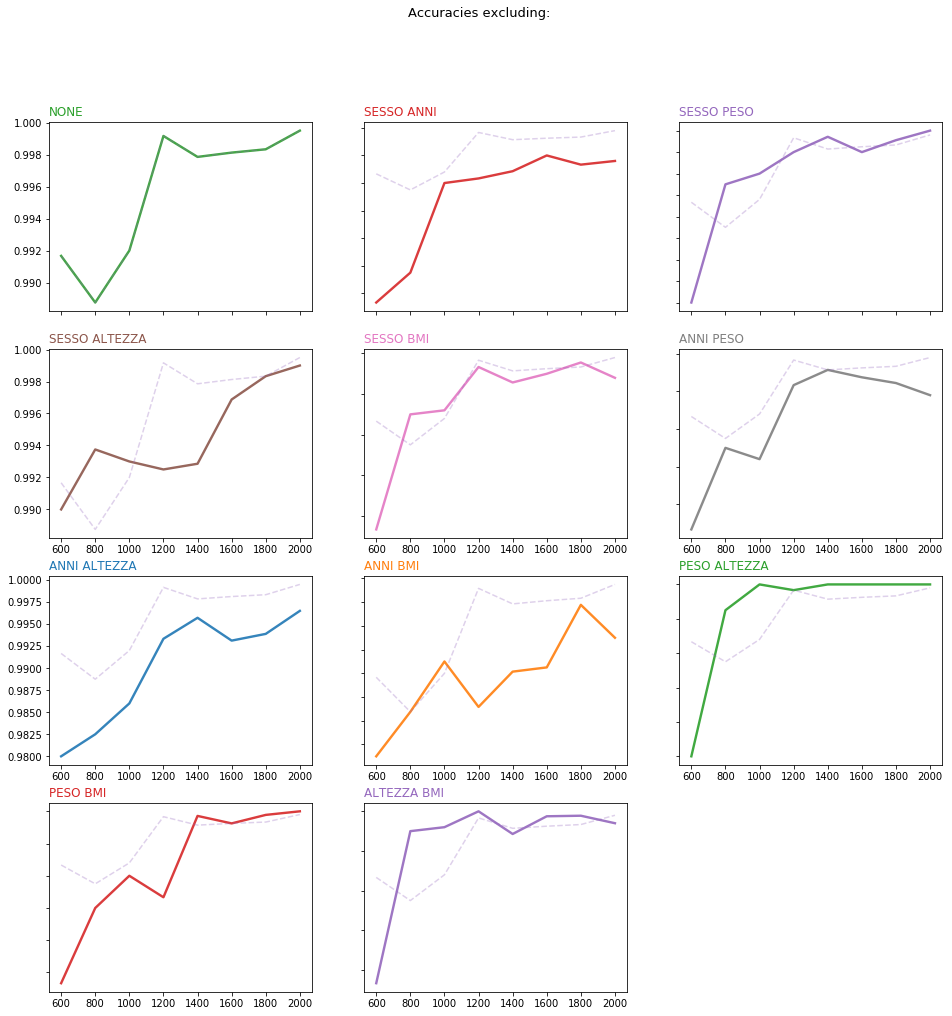

In [26]:
plt.figure(figsize=(16,16))
palette = plt.get_cmap('tab10')
 
num=0

for name in accuracies_excluding:
    num+=1
    
    score = accuracies_excluding[name]['best score']
    n_data = accuracies_excluding[name]['n_data']
    plt.subplot(4,3, num)

    plt.plot(n_data[6:], score[6:], marker='', color=palette((num+1)%8), linewidth=2.4, alpha=0.9)
    
    
    plt.plot(n_data[6:], accuracies_excluding['NONE']['best score'][6:],  linestyle='--', color=palette(4), alpha=0.3)

 
    if num in range(4) :
        plt.tick_params(labelbottom=False)
    if num not in [1,4,7] :
        plt.tick_params(labelleft=False)
        
    plt.title(name, loc='left', fontsize=12, fontweight=0, color=palette((num+1)%8) )
    
plt.suptitle("Accuracies excluding: ", fontsize=13, fontweight=0, color='black')
plt.show()

# Grafici delle accuracy escludendo un elemento alla volta aumentando i dati perturbando i dati sulle lesioni

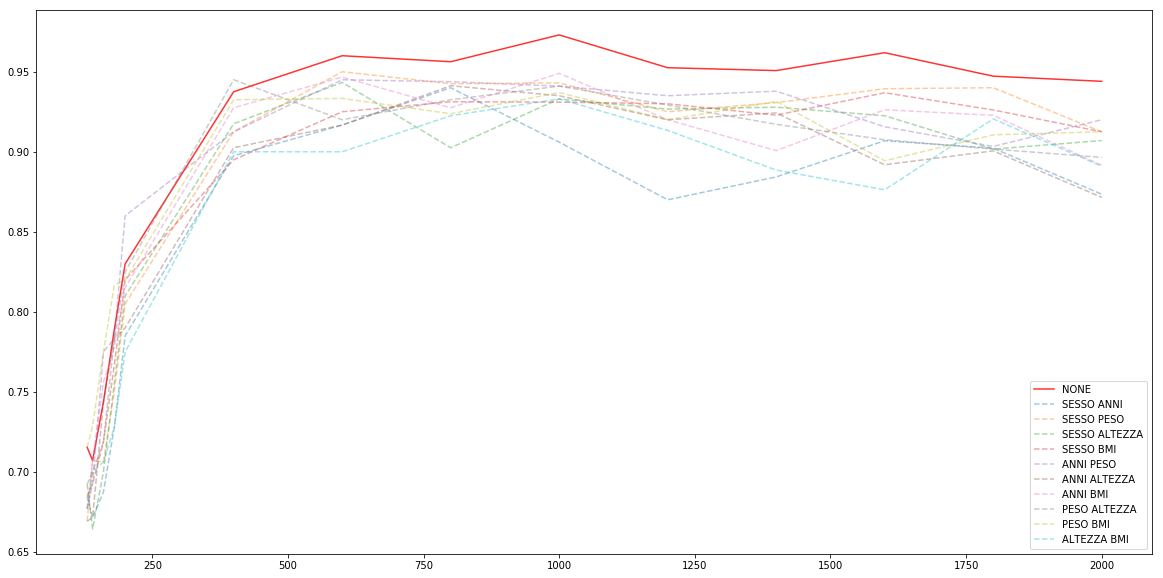

In [20]:
plt.figure(figsize=(20,10))

plt.plot(accuracies_excluding_body_parts['NONE']['n_data'], accuracies_excluding_body_parts['NONE']['best score'], alpha=0.8, color='red', label='NONE')

features = ['SESSO', 'ANNI', 'PESO', 'ALTEZZA', 'BMI']
for i in range(len(features)):
    for j in range(len(features)):
        if i < j : 
            excluded = features[i] + " " + features[j]
            plt.plot(accuracies_excluding_body_parts[excluded]['n_data'], accuracies_excluding_body_parts[excluded]['best score'], alpha=0.4, linestyle='--', label=excluded)

plt.legend(loc="lower right")
plt.show()

# Small multiples delle accuracy con reference le accuracy senza esclusioni

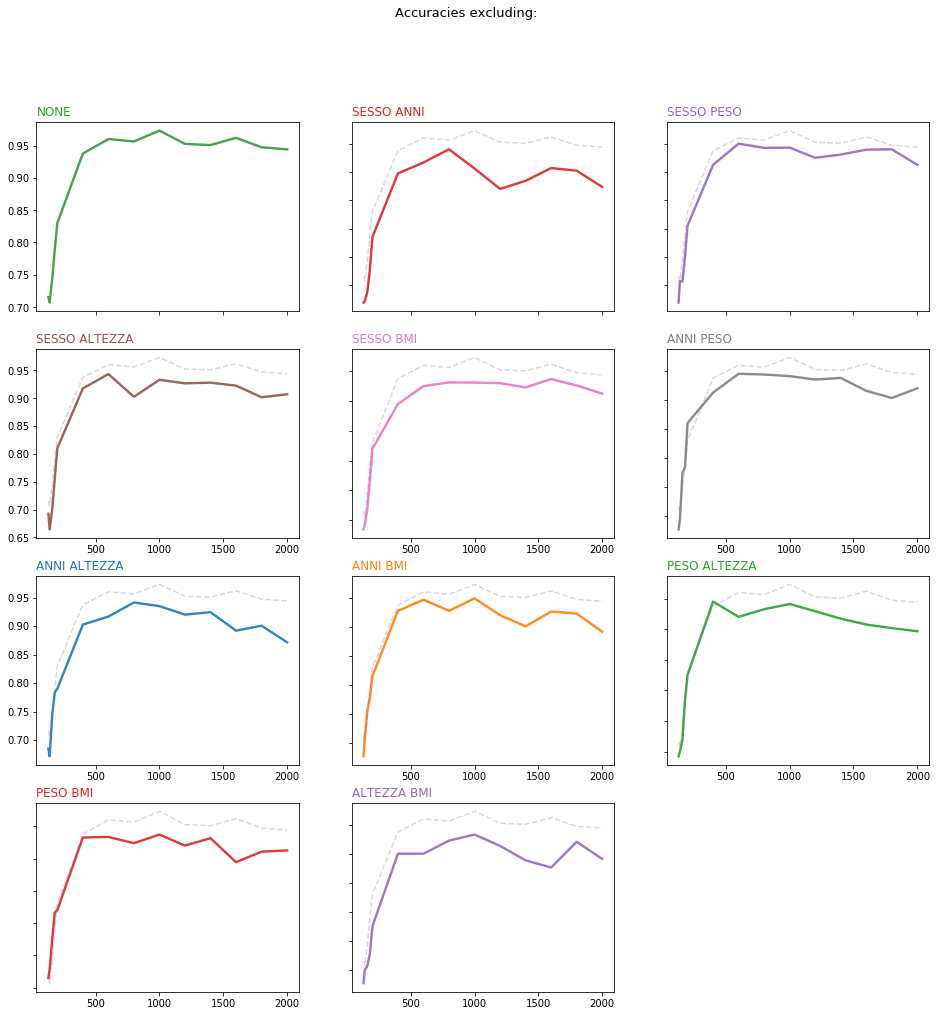

In [21]:
plt.figure(figsize=(16,16))
palette = plt.get_cmap('tab10')
 
num=0

for name in accuracies_excluding_body_parts:
    num+=1
    
    score = accuracies_excluding_body_parts[name]['best score']
    n_data = accuracies_excluding_body_parts[name]['n_data']
    plt.subplot(4,3, num)

    plt.plot(n_data, score, marker='', color=palette((num+1)%8), linewidth=2.4, alpha=0.9)
    
    
    plt.plot(n_data, accuracies_excluding_body_parts['NONE']['best score'], color=palette(4),  linestyle='--', alpha=0.3)

 
    if num in range(4) :
        plt.tick_params(labelbottom=False)
    if num not in [1,4,7] :
        plt.tick_params(labelleft=False)
        
    plt.title(name, loc='left', fontsize=12, fontweight=0, color=palette((num+1)%8) )
    
plt.suptitle("Accuracies excluding: ", fontsize=13, fontweight=0, color='black')
plt.show()

In [27]:
logging.info('Started augmenting data excluding NONE')
accuracies_excluding_both = {}
accuracies_excluding_both['NONE'] = get_accuracies(df, params, _range, perturbation_kind="both")

In [28]:
features = ['SESSO', 'ANNI', 'PESO', 'ALTEZZA', 'BMI']
for i in range(len(features)):
    for j in range(len(features)):
        if i < j : 
            excluded_features = [features[i], features[j]]
            logging.info('Started augmenting data excluding {0} and {1}'.format(features[i], features[j]))
            df_new = df.drop(columns= excluded_features)
            df_new['Mezzo'] = y
            accuracies_excluding_both[features[i] + " " + features[j]] = get_accuracies(df_new, params, _range, perturbation_kind="both", exclude=excluded_features, excluded_feature=df[excluded_features])

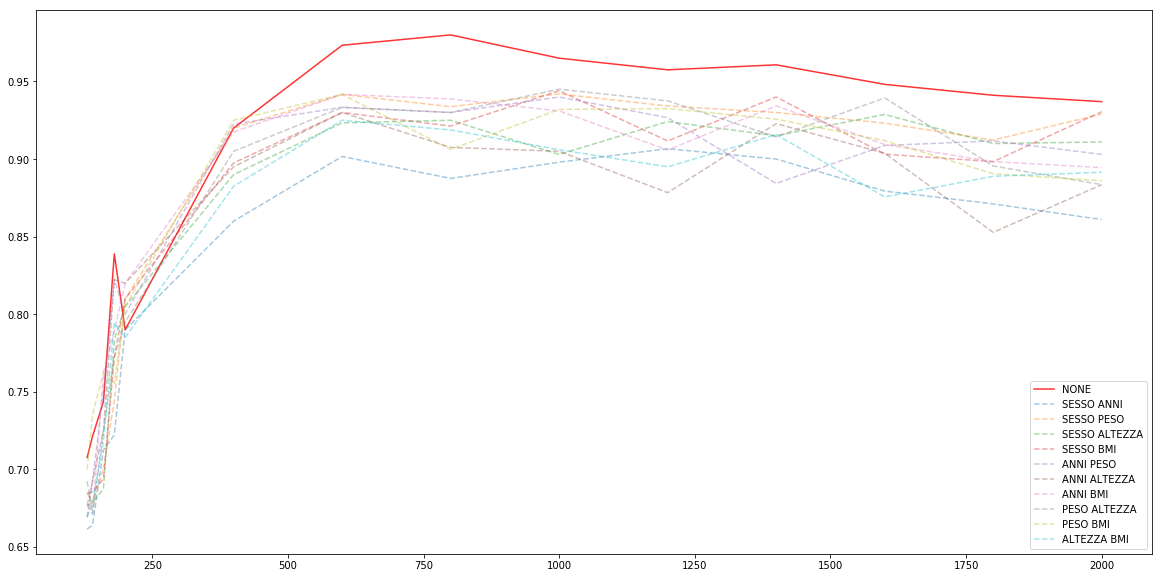

In [29]:
plt.figure(figsize=(20,10))

plt.plot(accuracies_excluding_both['NONE']['n_data'], accuracies_excluding_both['NONE']['best score'], alpha=0.8, color='red', label='NONE')

features = ['SESSO', 'ANNI', 'PESO', 'ALTEZZA', 'BMI']
for i in range(len(features)):
    for j in range(len(features)):
        if i < j : 
            excluded = features[i] + " " + features[j]
            plt.plot(accuracies_excluding_both[excluded]['n_data'], accuracies_excluding_both[excluded]['best score'], alpha=0.4, linestyle='--', label=excluded)

plt.legend(loc="lower right")
plt.show()

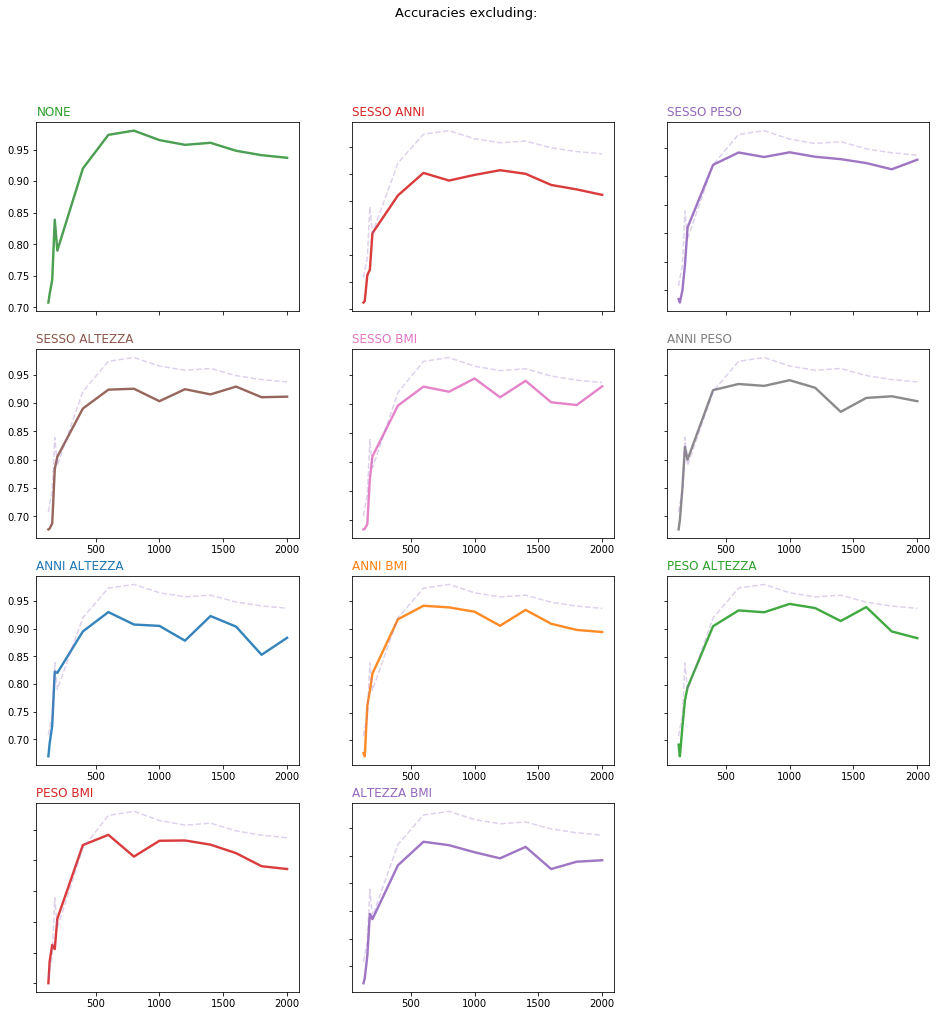

In [30]:
plt.figure(figsize=(16,16))
palette = plt.get_cmap('tab10')
 
num=0

for name in accuracies_excluding_both:
    num+=1
    
    score = accuracies_excluding_both[name]['best score']
    n_data = accuracies_excluding_both[name]['n_data']
    plt.subplot(4,3, num)

    plt.plot(n_data, score, marker='', color=palette((num+1)%8), linewidth=2.4, alpha=0.9)
    
    
    plt.plot(n_data, accuracies_excluding_both['NONE']['best score'], color=palette(4),  linestyle='--', alpha=0.3)

 
    if num in range(4) :
        plt.tick_params(labelbottom=False)
    if num not in [1,4,7] :
        plt.tick_params(labelleft=False)
        
    plt.title(name, loc='left', fontsize=12, fontweight=0, color=palette((num+1)%8) )
    
plt.suptitle("Accuracies excluding: ", fontsize=13, fontweight=0, color='black')
plt.show()